# **2ο ΜΕΡΟΣ: Ανίχνευση Σημείων Ενδιαφέροντος**                             

In [1]:
#Απαραίτητες Βιβλιοθήκες 
from IPython.display import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import ndimage, misc
import math
import sys
from matplotlib.patches import Circle

#Έτοιμες Συναρτήσεις:

In [2]:
def interest_points_visualization(I_, kp_data_,title,ax=None):
    '''
    Plot keypoints chosen by detectos on image.
    Args:
        I_: Image (if colored, make sure it is in RGB and not BGR).
        kp_data_: Nx3 array, as described in assignment.
        ax: Matplotlib axis to plot on (if None, a new Axes object is created).
    Returns:
        ax: Matplotlib axis where the image was plotted.
    '''
    try:
        I = np.array(I_)
        kp_data = np.array(kp_data_)
    except:
        print('Conversion to numpy arrays failed, check if the inputs (image and keypoints) are in the required format.')
        exit(2)

    try:
        assert(len(I.shape) == 2 or (len(I.shape) == 3 and I.shape[2] == 3))
    except AssertionError as e:
        print('interest_points_visualization: Image must be either a 2D matrix or a 3D matrix with the last dimension having size equal to 3.', file=sys.stderr)
        exit(2)

    try:
        assert(len(kp_data.shape) == 2 and kp_data.shape[1] == 3)
    except AssertionError as e:
        print('interest_points_visualization: kp_data must be a 2D matrix with 3 columns.', file=sys.stderr)
        exit(2)

    if ax is None:
        _, ax = plt.subplots(figsize=(20, 10))

    ax.set_aspect('equal')
    ax.set_title(title, fontsize=20)
    ax.imshow(I)
    ax.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

    for i in range(len(kp_data)):
        x, y, sigma = kp_data[i]
        circ = Circle((x, y), 3*sigma, edgecolor='g', fill=False, linewidth=2)
        ax.add_patch(circ)

    return ax

In [3]:
def disk_strel(n):
    '''
        Return a structural element, which is a disk of radius n.
    '''
    r = int(np.round(n))
    d = 2*r+1
    x = np.arange(d) - r
    y = np.arange(d) - r
    x, y = np.meshgrid(x,y)
    strel = x**2 + y**2 <= r**2
    return strel.astype(np.uint8)

# Ανάγνωση - Κανονικοποίηση - Εμφάνιση Εικόνας #

In [4]:
#n_img1: Κανονικοποιημένη Ασπρόμαυρη Εικόνα 
img1 = cv2.imread('Caravaggio2.jpg',cv2.IMREAD_GRAYSCALE)
n_img1 = img1.astype(np.float)/255

#n_img2: Κανονικοποιημένη Έγχρωμη Εικόνα 
img2 = cv2.imread('Caravaggio2.jpg')
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
n_img2 = cv2.normalize(img2.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)

Text(0.5, 1.0, 'Έγχρωμη Εικόνα')

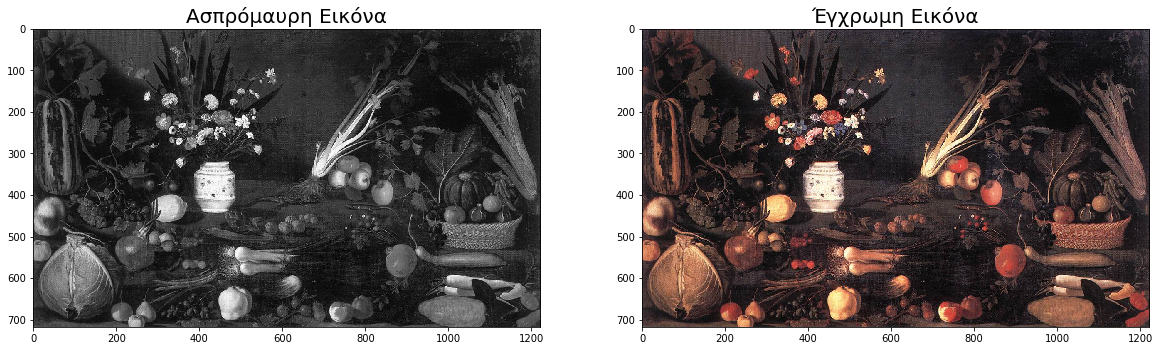

In [5]:
#Εμφάνιση Εικόνων 

f, (ax0,ax1) = plt.subplots(1, 2, figsize=(20, 10))

ax0.imshow(n_img1,cmap='gray')
ax0.set_title("Aσπρόμαυρη Εικόνα" , fontsize=20)

ax1.imshow(n_img2,cmap='gray')
ax1.set_title("Έγχρωμη Εικόνα" , fontsize=20)

# **2.1. Ανίχνευση Γωνιών**



Text(0.5, 1.0, 'Eξομάλυνση Εικόνας')

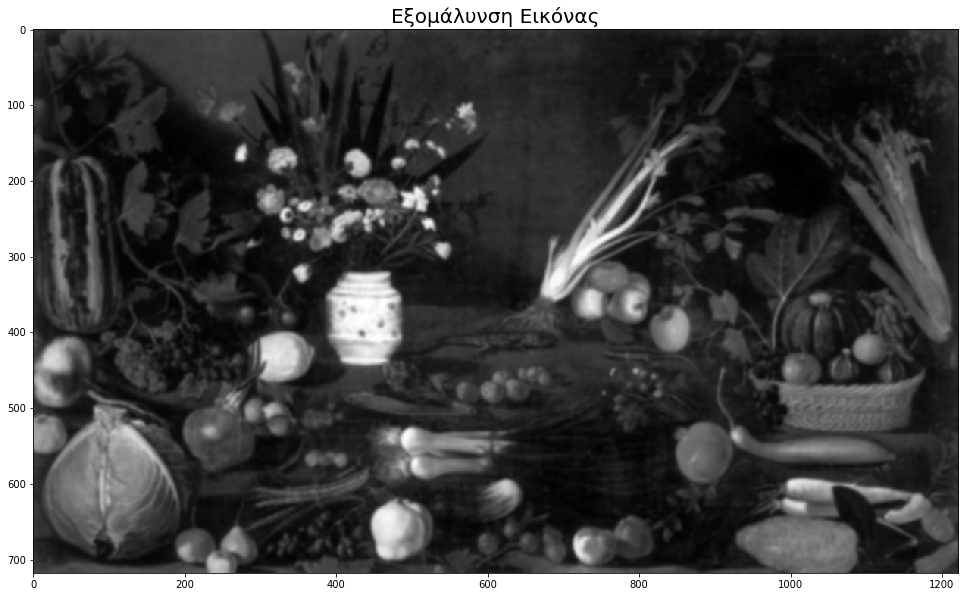

In [6]:
#Εξομάλυνση εικόνας

s =2
r= 2.5

ns = int(2*np.ceil(3*s)+1)
rs = int(2*np.ceil(3*r)+1)


gauss1Ds = cv2.getGaussianKernel(ns, s) # Column vector
gauss2Ds = gauss1Ds @ gauss1Ds.T        # Symmetric gaussian kernel

gauss1Dr = cv2.getGaussianKernel(rs, r) # Column vector
gauss2Dr = gauss1Dr @ gauss1Dr.T        # Symmetric gaussian kernel



Is_1 = cv2.filter2D(n_img1, -1, gauss2Ds)


f, (ax0) = plt.subplots(1, 1, figsize=(20, 10))
ax0.imshow(Is_1 ,cmap='gray')
ax0.set_title("Eξομάλυνση Εικόνας" , fontsize=20)



# 2.1.1. Υπολογίσμός J1, J2 και J3

In [7]:
[dx,dy] = np.gradient(Is_1)

#2.1.1 Υπολογισμος J
dxdx=np.multiply(dx,dx)
dxdy=np.multiply(dx,dy)
dydy=np.multiply(dy,dy)

J1 = cv2.filter2D(dxdx, -1, gauss2Dr)
J2 = cv2.filter2D(dxdy, -1, gauss2Dr)
J3 = cv2.filter2D(dydy, -1, gauss2Dr)

# 2.1.2. Υπολογισμός Ιδιοτιμών Τανυστή J

Text(0.5, 1.0, 'Αρνητικές Ιδιοτιμές (λ-)')

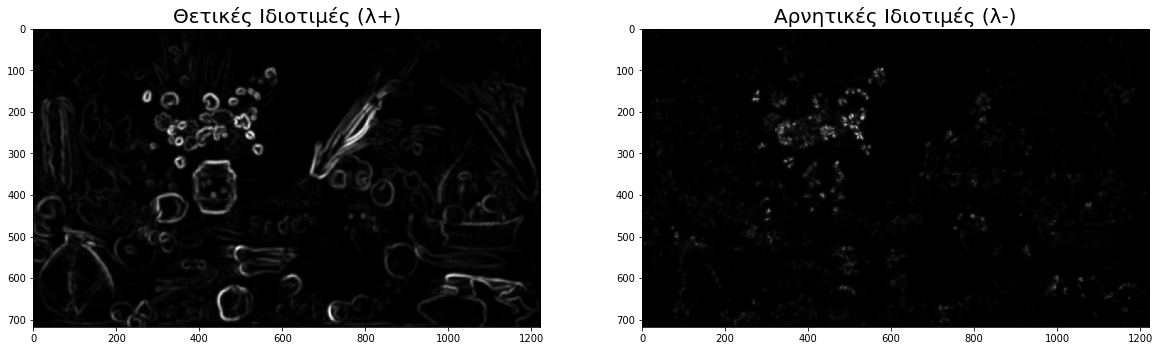

In [8]:
# 2.1.2 Υπολογισμός λ1,λ2

J1minusJ3sq = np.multiply((J1-J3),(J1-J3))
J2sq        = np.multiply(J2,J2)
lplus       = 0.5*(J1 + J3 + np.sqrt(J1minusJ3sq + 4*J2sq));
lminus      = 0.5*(J1 + J3 - np.sqrt(J1minusJ3sq + 4*J2sq));

f, (ax0,ax1) = plt.subplots(1, 2, figsize=(20, 10))

ax0.imshow(np.real(lplus),cmap='gray')
ax0.set_title("Θετικές Ιδιοτιμές (λ+)" , fontsize=20)

ax1.imshow(np.real(lminus),cmap='gray')
ax1.set_title("Αρνητικές Ιδιοτιμές (λ-)" , fontsize=20)


# 2.1.3. Κριτήριο Γωνιότητας R

In [9]:
k = 0.05
R = np.multiply(lplus,lminus)-k*np.multiply(lplus+lminus,lplus+lminus)

#Συνθήκη 1 
ns = np.ceil(3*s)*2+1
B_sq = disk_strel(ns)
Cond1 = (R==cv2.dilate(R,B_sq))
Cond1=Cond1*1

#Συνθήκη 2
thetacorn = 0.005;
maxR=np.amax(R)
Cond2 = ( R >= thetacorn*maxR);
Cond2=Cond2*1

y1,x1 = np.where(Cond1 & Cond2)
array_sc = np.ones(y1.shape[0])
param = np.column_stack([x1,y1,array_sc])


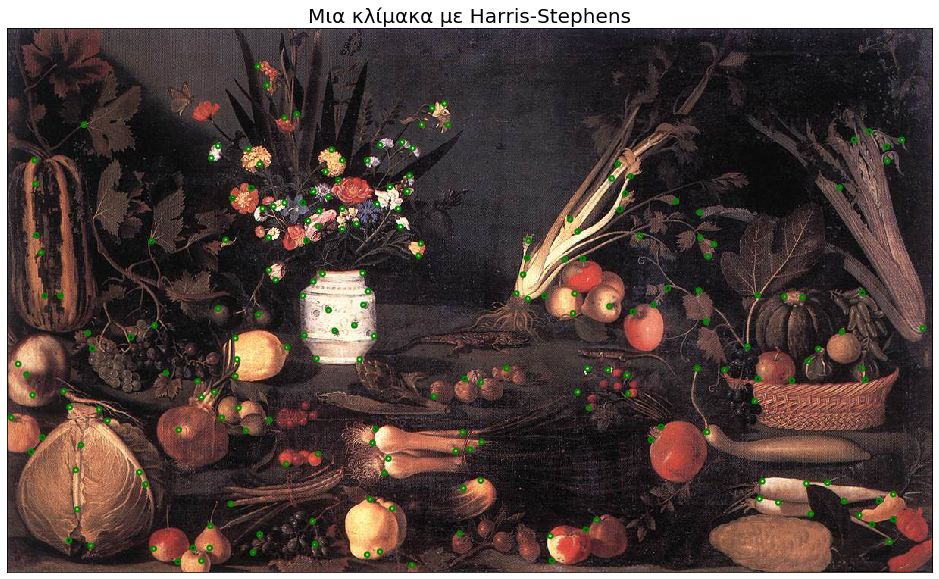

In [10]:
interest_points_visualization(n_img2,param,"Μια κλίμακα με Harris-Stephens")

#**2.2 Πολυκλιμακωτή Ανίχνευση Γωνιών**

# 2.2.1 Eύρεση γωνιών μονής κλίμακας για διαφορετικές κλίμακες

In [11]:
#Όλα τα παραπάνω ομαδοποιούνται σε μια συνάρτηση 
def harris_laplacian_for_one_scale(I,s,r,k):
  ns = int(2*np.ceil(3*s)+1)
  rs = int(2*np.ceil(3*r)+1)


  gauss1Ds = cv2.getGaussianKernel(ns, s)
  gauss2Ds = gauss1Ds @ gauss1Ds.T        

  gauss1Dr = cv2.getGaussianKernel(rs, r) 
  gauss2Dr = gauss1Dr @ gauss1Dr.T        


  Is_1 = cv2.filter2D(n_img1, -1, gauss2Ds)

  [dx,dy] = np.gradient(Is_1)

  
  dxdx=np.multiply(dx,dx)
  dxdy=np.multiply(dx,dy)
  dydy=np.multiply(dy,dy)

  J1 = cv2.filter2D(dxdx, -1, gauss2Dr)
  J2 = cv2.filter2D(dxdy, -1, gauss2Dr)
  J3 = cv2.filter2D(dydy, -1, gauss2Dr)

  J1minusJ3sq = np.multiply((J1-J3),(J1-J3))
  J2sq        = np.multiply(J2,J2)
  lplus       = 0.5*(J1 + J3 + np.sqrt(J1minusJ3sq + 4*J2sq))
  lminus      = 0.5*(J1 + J3 - np.sqrt(J1minusJ3sq + 4*J2sq))

  R = np.multiply(lplus,lminus)-k*np.multiply(lplus+lminus,lplus+lminus)

  #Συνθήκη 1 
  ns = np.ceil(3*s)*2+1
  B_sq = disk_strel(ns)
  Cond1 = (R==cv2.dilate(R,B_sq))
  Cond1=Cond1*1

  #Συνθήκη 2
  thetacorn = 0.005;
  maxR=np.amax(R)
  Cond2 = ( R >= thetacorn*maxR);
  Cond2=Cond2*1

  y1,x1 = np.where(Cond1 & Cond2)
  array_sc = np.ones(y1.shape[0])
  param = np.column_stack([x1,y1,array_sc])

  return param

# 2.2.2. Πολυκλιμακωτή Ανίχνευση Γωνιών (Harris-Laplacian)

In [12]:
#LoG για διάφορες κλίμακες 
def compute_Log(N,s0,scale,I):
  AbsLog = np.zeros((I.shape[0],I.shape[1],N))
  for K in range(N):
    s=s0*scale**(K)
    Log_I = ndimage.gaussian_laplace(I,s)
    AbsLog[:,:,K] = s*s * abs(Log_I)
  return AbsLog

In [13]:
#2.2. Πολυκλιμακωτή Ανίχνευση Γωνιών
s0=2;
r0=2.5;
k=0.05;
thetacorn = 0.005;
scale=1.5;
N=4;

AbsLog = compute_Log(N,s0,scale,n_img1);

for i in range(N):
  s=s0*scale**i;
  r=r0*scale**i;

  ns = int(2*np.ceil(3*s)+1)
  rs = int(2*np.ceil(3*r)+1)

  gauss1Ds = cv2.getGaussianKernel(ns, s) # Column vector
  gauss2Ds = gauss1Ds @ gauss1Ds.T        # Symmetric gaussian kernel

  gauss1Dr = cv2.getGaussianKernel(rs, r) # Column vector
  gauss2Dr = gauss1Dr @ gauss1Dr.T        # Symmetric gaussian kernel

  Is_1 = cv2.filter2D(n_img1, -1, gauss2Ds)
  [dx,dy] = np.gradient(Is_1)

  dxdx=np.multiply(dx,dx)
  dxdy=np.multiply(dx,dy)
  dydy=np.multiply(dy,dy)

  J1 = cv2.filter2D(dxdx, -1, gauss2Dr)
  J2 = cv2.filter2D(dxdy, -1, gauss2Dr)
  J3 = cv2.filter2D(dydy, -1, gauss2Dr)

  J1minusJ3sq = np.multiply((J1-J3),(J1-J3))
  J2sq        = np.multiply(J2,J2)
  lplus       = 0.5*(J1 + J3 + np.sqrt(J1minusJ3sq + 4*J2sq));
  lminus      = 0.5*(J1 + J3 - np.sqrt(J1minusJ3sq + 4*J2sq));

  R = np.multiply(lplus,lminus)-k*np.multiply(lplus+lminus,lplus+lminus)

  ns = np.ceil(3*s)*2+1
  B_sq = disk_strel(ns)
  Cond1 = (R==cv2.dilate(R,B_sq))
  Cond1=Cond1*1

  maxR=np.amax(R)
  Cond2 = ( R >= thetacorn*maxR);
  Cond2=Cond2*1

  if (i==0):
     AbsLogCond = AbsLog[:,:,i] >= AbsLog[:,:,i+1]
  elif (i==N-1):
    AbsLogCond= AbsLog[:,:,i] >= AbsLog[:,:,i-1]
  else:
     AbsLogCond = (AbsLog[:,:,i] >= AbsLog[:,:,i+1])& (AbsLog[:,:,i] >= AbsLog[:,:,i-1])

  temp_y,temp_x = np.where(Cond1 & Cond2 & AbsLogCond)

  a=temp_x.shape[0]
  #print(a)

  temp = np.ones((a))*s

  Temp_Parameters= np.concatenate((temp_x, temp_y,temp), axis=0)
  Temp_Parameters= np.reshape(Temp_Parameters,(3,a))
  Temp_Parameters= np.transpose(Temp_Parameters)
  
  if (i==0):
    Parameters = Temp_Parameters
  else:
    Parameters = np.concatenate((Temp_Parameters,Parameters), axis=0)



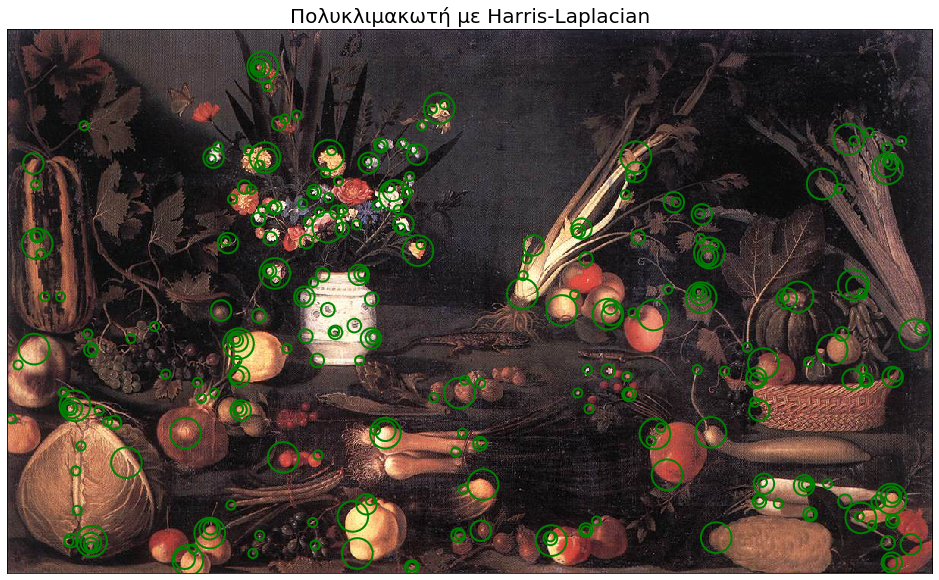

In [14]:
interest_points_visualization(n_img2,Parameters,"Πολυκλιμακωτή με Harris-Laplacian")

# **2.3 Ανίχνευση Blobs**

# 2.3.1. Υπολογίσμός Μερικών Παραγώγων Δεύτερης Τάξης της Εικόνας

In [15]:
def hessian_criterion(I,s):
  ns = int(2*np.ceil(3*s)+1)
  n_img1=I

  gauss1Ds = cv2.getGaussianKernel(ns, s) # Column vector
  gauss2Ds = gauss1Ds @ gauss1Ds.T # Symmetric gaussian kernel

  Is_1 = cv2.filter2D(n_img1, -1, gauss2Ds)
  [dx,dy] = np.gradient(Is_1)

  [hxx,hxy]=np.gradient(dx)
  [hxy,hyy]=np.gradient(dy)

  R = np.multiply(hxx,hyy)-np.multiply(hxy,hxy)
  return R

Text(0.5, 1.0, 'scale = 9')

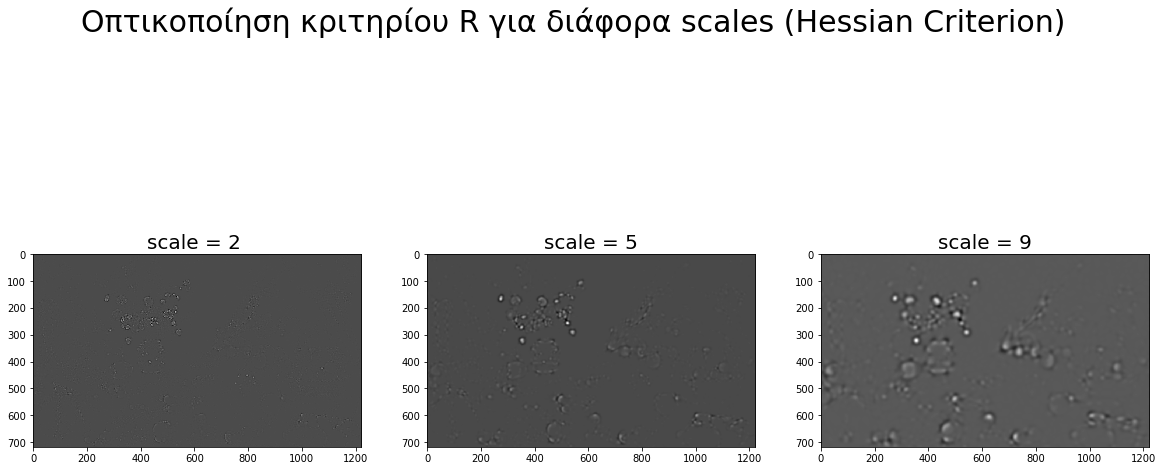

In [16]:
R1= hessian_criterion(n_img1,2.2)
R2= hessian_criterion(n_img1,5.2)
R3= hessian_criterion(n_img1,9.2)

f, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20, 10))

f.suptitle('Οπτικοποίηση κριτηρίου R για διάφορα scales (Hessian Criterion)',fontsize=30)

ax0.imshow(R1,cmap='gray')
ax0.set_title("scale = 2 ",fontsize=20)

ax1.imshow(R2,cmap='gray')
ax1.set_title("scale = 5" , fontsize=20)

ax2.imshow(R3,cmap='gray')
ax2.set_title("scale = 9" , fontsize=20)

# 2.3.2. Επιλογή Σημείων Ενδιαφέροντος 

In [17]:
s =2
ns = int(2*np.ceil(3*s)+1)

gauss1Ds = cv2.getGaussianKernel(ns, s) # Column vector
gauss2Ds = gauss1Ds @ gauss1Ds.T # Symmetric gaussian kernel

Is_1 = cv2.filter2D(n_img1, -1, gauss2Ds)
[dx,dy] = np.gradient(Is_1)

[hxx,hxy]=np.gradient(dx)
[hxy,hyy]=np.gradient(dy)

R = np.multiply(hxx,hyy)-np.multiply(hxy,hxy)

B_sq = disk_strel(ns);
maxima = (R==cv2.dilate(R,B_sq))
Rmax = np.amax(R)


threshold = 0.07
temp_y,temp_x = np.where(maxima & (R>= (threshold * Rmax)))

array_sc = np.ones(temp_y.shape[0])*s

param = np.column_stack([temp_x,temp_y,array_sc])

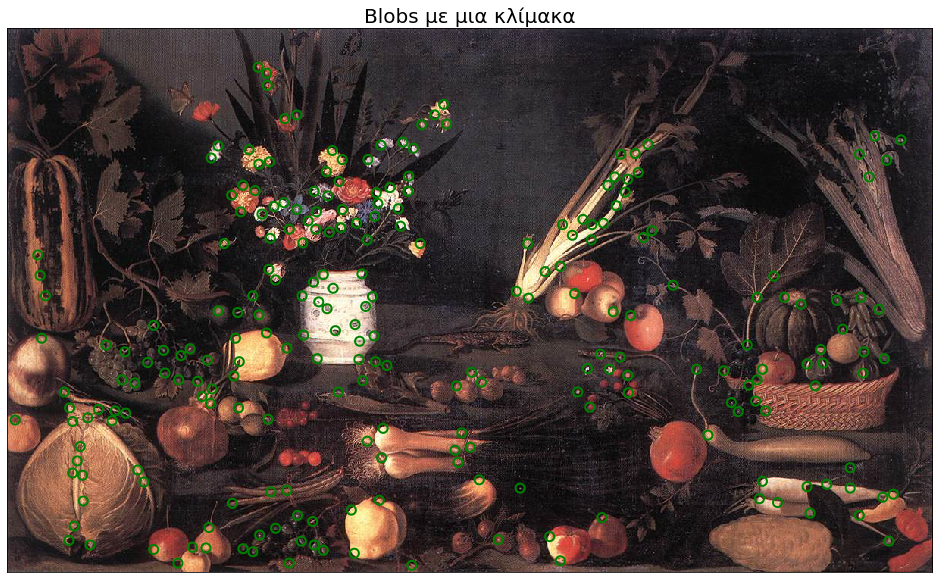

In [18]:
interest_points_visualization(n_img2,param,"Blobs με μια κλίμακα")

# **2.4 Πολυκλιμακωτή Ανίχνευση Blobs**

# 2.4.1 Πολυκλιμακωτή Ανίχνευση Γωνιών (Blobs)

In [19]:
#Καθορισμός Παραμέτρων 
N=4;
s0=s;
scale=1.85;
threshold = 0.07;
AbsLog = compute_Log( N, s0,scale ,n_img1)

In [20]:
for i in range(N):
  s=s0*scale**i

  ns = int(2*np.ceil(3*s)+1)

  gauss1Ds = cv2.getGaussianKernel(ns, s) # Column vector
  gauss2Ds = gauss1Ds @ gauss1Ds.T        # Symmetric gaussian kernel

  Is_1 = cv2.filter2D(n_img1, -1, gauss2Ds)
  
  [dx,dy] = np.gradient(Is_1)
  [hxx,hxy]=np.gradient(dx)
  [hxy,hyy]=np.gradient(dy)


  R = np.multiply(hxx,hyy)-np.multiply(hxy,hxy)

  B_sq = disk_strel(ns);
  maxima = (R==cv2.dilate(R,B_sq))
  Rmax = np.amax(R)

  if (i==0):
     AbsLogCond = AbsLog[:,:,i] >= AbsLog[:,:,i+1]
  elif (i==N-1):
    AbsLogCond= AbsLog[:,:,i] >= AbsLog[:,:,i-1]
  else:
     AbsLogCond = (AbsLog[:,:,i] >= AbsLog[:,:,i+1])& (AbsLog[:,:,i] >= AbsLog[:,:,i-1])

  temp_y,temp_x = np.where(maxima & (R>= (threshold * Rmax)) & AbsLogCond)

  a=temp_x.shape[0]
  #print(a)

  temp = np.ones((a))*s

  Temp_Parameters= np.concatenate((temp_x, temp_y,temp), axis=0)
  Temp_Parameters= np.reshape(Temp_Parameters,(3,a))
  Temp_Parameters= np.transpose(Temp_Parameters)
  
  if (i==0):
    Parameters = Temp_Parameters
  else:
    Parameters = np.concatenate((Temp_Parameters,Parameters), axis=0)




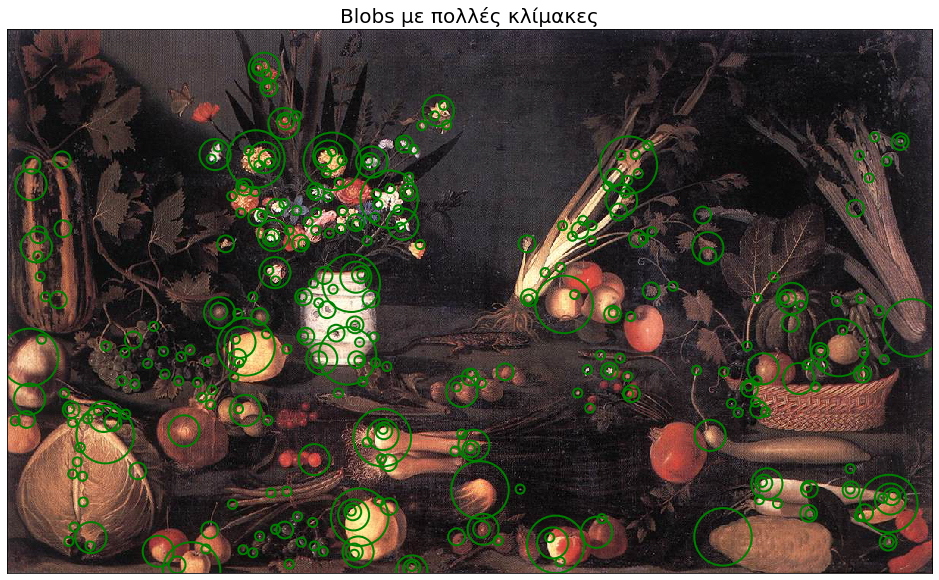

In [21]:
interest_points_visualization(n_img2,Parameters,"Blobs με πολλές κλίμακες")

# 2.5.1. Υπολογισμός Ολοκληρωτικής Εικόνας 

Text(0.5, 1.0, 'Oλοκληρωική εικόνα μετά απο edge-replicate padding')

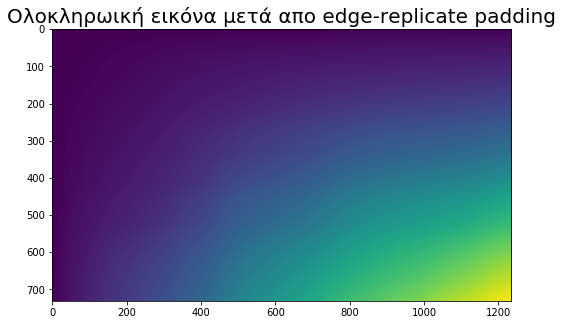

In [22]:
s=2
n=np.ceil(3*s)*2+1
Ipad=np.pad(n_img1,(math.floor(n/2),math.floor(n/2)),'edge')
integral_image=cv2.integral(Ipad)

f, (ax0) = plt.subplots(1, 1, figsize=(10, 5))
ax0.imshow(integral_image)
ax0.set_title("Oλοκληρωική εικόνα μετά απο edge-replicate padding" , fontsize=20)


In [23]:
def computeSs_Integral(intI, shiftX, shiftY, offsetx, offsety):
  sD = np.roll(intI,-shiftY + offsety,0)
  sD = np.roll(sD,-shiftX + offsetx,1)
  #Left-Top Corner
  sA = np.roll(intI,shiftY + offsety,0)
  sA = np.roll(sA,shiftX + offsetx,1)
  #Right-Top corner
  sB = np.roll(intI,shiftY + offsety,0)
  sB = np.roll(sB,-shiftX + offsetx,1)
  #Left-Bottom Corner
  sC = np.roll(intI,-shiftY + offsety,0)
  sC = np.roll(sC,shiftX + offsetx,1)
  return [sA,sB,sC,sD]


In [24]:
def unpad ( temp_s , pad ):
  sx = temp_s.shape[0]
  sy = temp_s.shape[1]
  s = temp_s[pad:sx - pad+1,pad:sy - pad+1]
  return s

# 2.5.2 Υπολογισμός των Lxx, Lxy, Lyy με χρήση της Ολοκληρωτικής Εικόνας

In [25]:
def box_filters_one_scale(I,s):
  thresh=0.912
  threshold = 0.07
  #threshold = 0.02
  n = np.ceil(3*s)*2+1
  
  xDxx = 2*math.floor(n/6) + 1
  yDxx = 4*math.floor(n/6) + 1
  rDxx = math.floor((n-yDxx)/2)
  
  xDyy = 4*math.floor(n/6) + 1
  yDyy = 2*math.floor(n/6) + 1
  
  xDxy = 2*math.floor(n/6)+1
  yDxy = 2*math.floor(n/6)+1
  rDxy =math.floor((n - xDxy - yDxy)/3)
  
  sDxy = math.floor((n - xDxy - yDxy)/3)
  mDxy = np.ceil((n - xDxy - yDxy)/3)

  if(sDxy + sDxy + mDxy != n-xDxy - yDxy):
    sDxy = np.ceil((n - xDxy - yDxy)/3)
    mDxy = math.floor((n - xDxy - yDxy)/3)

  Ipadded=np.pad(n_img1,(math.floor(n/2),math.floor(n/2)),'edge')
  intI=cv2.integral(Ipadded)

  #Central Box
  magn = -3
  shiftX = (xDxx -1)//2
  shiftY = (yDxx -1)//2
  pad = math.floor(n/2) + 1
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY , 0, 0)
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad)
  Lxx = (sD + sA - sB - sC) * magn

  #Left and Right Box
  magn = 1
  shiftX = (xDxx -1)//2 + xDxx
  shiftY = (yDxx -1)//2
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY ,0, 0)
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad)
  Lxx = (sD + sA - sB - sC) * magn + Lxx


  # Lyy
  #Central Box
  magn = -3
  shiftX = (xDyy -1)//2
  shiftY = (yDyy -1)//2
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY ,0, 0)
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad);
  Lyy = (sD + sA - sB - sC) * magn
  
  #Top and Bottom Box
  magn = 1;
  shiftX = (xDyy -1)//2
  shiftY = (yDyy -1)//2 + yDyy
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY , 0 , 0)
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad)
  Lyy = (sD + sA - sB - sC) * magn + Lyy




  if(( math.floor(np.ceil((n-2*xDxy)/3) % 2)) == 1):
    rDxy = np.ceil((n-2*xDxy)/3)
  else:
    rDxy = math.floor((n-2*xDxy)/3)



  # Lxy
  #Top Right Box
  magn = -1
  offsetx = - math.floor((rDxy-1)/2) -  math.floor((xDxy -1)/2)
  offsety =  math.floor((rDxy-1)/2) +  math.floor((yDxy -1)/2)
  shiftX =  math.floor((xDxy -1)/2)
  shiftY =  math.floor((yDxy -1)/2)
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY, offsetx, offsety )
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad)
  Lxy = (sD + sA - sB - sC) * magn
  
  #Top Left Box
  magn = 1
  offsetx =  math.floor((rDxy-1)/2) +  math.floor((xDxy -1)/2)
  offsety =  math.floor((rDxy-1)/2) +  math.floor((yDxy -1)/2)
  shiftX =  math.floor((xDxy -1)/2)
  shiftY =  math.floor((yDxy -1)/2)
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY, offsetx, offsety  )
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad)
  Lxy = (sD + sA - sB - sC) * magn + Lxy
  
  #Bottom Left Box
  magn = -1
  offsetx =  math.floor((rDxy-1)/2) +  math.floor((xDxy -1)/2)
  offsety = - math.floor((rDxy-1)/2) -  math.floor((yDxy -1)/2)
  shiftX =  math.floor((xDxy -1)/2)
  shiftY =  math.floor((yDxy -1)/2)
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY, offsetx, offsety  )
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad)
  Lxy = (sD + sA - sB - sC) * magn + Lxy
 
  #Bottom Right Box
  magn = 1;
  offsetx = - math.floor((rDxy-1)/2) -  math.floor((xDxy -1)/2)
  offsety = - math.floor((rDxy-1)/2) -  math.floor((yDxy -1)/2)
  shiftX  =  math.floor((xDxy -1)/2)
  shiftY  =  math.floor((yDxy -1)/2)
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY, offsetx, offsety  )
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad)
  Lxy = (sD + sA - sB - sC) * magn + Lxy

  
  
  R=np.multiply(Lxx,Lyy) - np.power((thresh*Lxy),2)

  
  #Finds maxima
  ns=np.ceil(3*s)*2+1
  B_sq = disk_strel(ns)
  maxima = (R==cv2.dilate(R,B_sq))
  Rmax = np.amax(R)

  interest_map = (maxima & (R >= threshold * Rmax)) 

  return interest_map 




# 2.5.4 Πολυκλιμακωτή Ανίχνευση Γωνιών (Box Filters)

In [26]:
N = 4;
s0 = 2.5;
scale = 1.78;



AbsLog = compute_Log(N, s0,scale ,n_img1)

for i in range(4):
  s = s0 * scale**i

  interest_map=box_filters_one_scale(n_img1,s)
  
  if (i==0):
     AbsLogCond = AbsLog[:,:,i] >= AbsLog[:,:,i+1]
  elif (i==3):
    AbsLogCond= AbsLog[:,:,i] >= AbsLog[:,:,i-1]
  else:
     AbsLogCond = (AbsLog[:,:,i] >= AbsLog[:,:,i+1])& (AbsLog[:,:,i] >= AbsLog[:,:,i-1])



  temp_y,temp_x = np.where(interest_map & AbsLogCond)
  a=temp_x.shape[0]
  #print(a)

  temp = np.ones((a))*s

  Temp_Parameters= np.concatenate((temp_x, temp_y,temp), axis=0)
  Temp_Parameters= np.reshape(Temp_Parameters,(3,a))
  Temp_Parameters= np.transpose(Temp_Parameters)
  
  if (i==0):
    Parameters = Temp_Parameters
  else:
    Parameters = np.concatenate((Temp_Parameters,Parameters), axis=0)
print(Parameters.shape)

(289, 3)


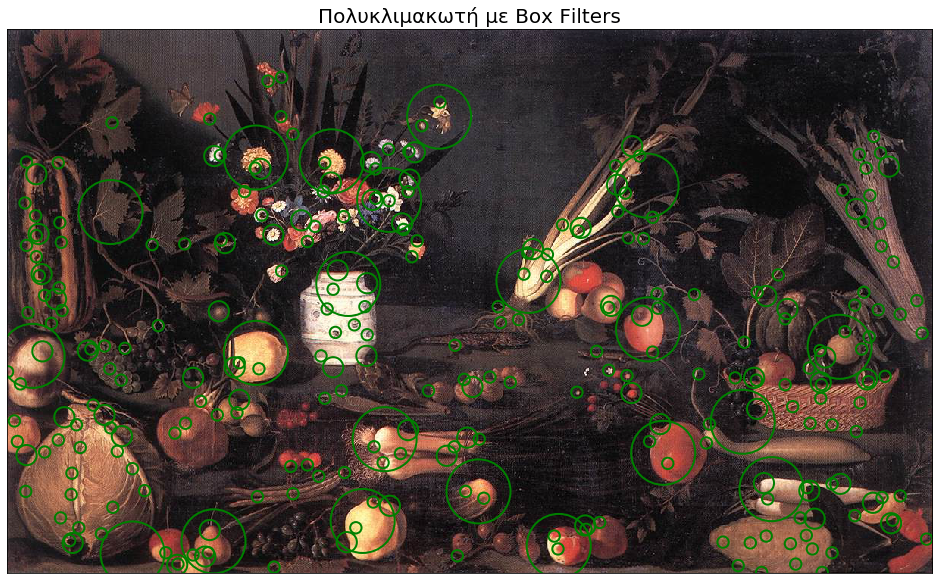

In [27]:
interest_points_visualization(n_img2,Parameters,"Πολυκλιμακωτή με Box Filters")

# 2.5.3 Οπτικοποίηση Κριτηρίου R

In [28]:
def box_filters_criterion(I,s):

  n = np.ceil(3*s)*2+1
  thresh=0.912
  n_img1=I

  xDxx = 2*math.floor(n/6) + 1
  yDxx = 4*math.floor(n/6) + 1
  rDxx = math.floor((n-yDxx)/2)

  xDyy = 4*math.floor(n/6) + 1
  yDyy = 2*math.floor(n/6) + 1

  xDxy = 2*math.floor(n/6)+1
  yDxy = 2*math.floor(n/6)+1
  rDxy =math.floor((n - xDxy - yDxy)/3)

  sDxy = math.floor((n - xDxy - yDxy)/3)
  mDxy = np.ceil((n - xDxy - yDxy)/3)

  if(sDxy + sDxy + mDxy != n-xDxy - yDxy):
    sDxy = np.ceil((n - xDxy - yDxy)/3)
    mDxy = math.floor((n - xDxy - yDxy)/3)

  Ipadded=np.pad(n_img1,(math.floor(n/2),math.floor(n/2)),'edge')
  intI=cv2.integral(Ipadded)

  #Central Box
  magn = -3
  shiftX = (xDxx -1)//2
  shiftY = (yDxx -1)//2
  pad = math.floor(n/2) + 1
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY , 0, 0)
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad)
  Lxx = (sD + sA - sB - sC) * magn

  #Left and Right Box
  magn = 1
  shiftX = (xDxx -1)//2 + xDxx
  shiftY = (yDxx -1)//2
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY ,0, 0)
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad)
  Lxx = (sD + sA - sB - sC) * magn + Lxx


  # Lyy
  #Central Box
  magn = -3
  shiftX = (xDyy -1)//2
  shiftY = (yDyy -1)//2
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY ,0, 0)
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad);
  Lyy = (sD + sA - sB - sC) * magn

  #Top and Bottom Box
  magn = 1;
  shiftX = (xDyy -1)//2
  shiftY = (yDyy -1)//2 + yDyy
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY , 0 , 0)
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad)
  Lyy = (sD + sA - sB - sC) * magn + Lyy




  if(( math.floor(np.ceil((n-2*xDxy)/3) % 2)) == 1):
    rDxy = np.ceil((n-2*xDxy)/3)
  else:
    rDxy = math.floor((n-2*xDxy)/3)



  # Lxy
  #Top Right Box
  magn = -1
  offsetx = - math.floor((rDxy-1)/2) -  math.floor((xDxy -1)/2)
  offsety =  math.floor((rDxy-1)/2) +  math.floor((yDxy -1)/2)
  shiftX =  math.floor((xDxy -1)/2)
  shiftY =  math.floor((yDxy -1)/2)
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY, offsetx, offsety )
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad)
  Lxy = (sD + sA - sB - sC) * magn

  #Top Left Box
  magn = 1
  offsetx =  math.floor((rDxy-1)/2) +  math.floor((xDxy -1)/2)
  offsety =  math.floor((rDxy-1)/2) +  math.floor((yDxy -1)/2)
  shiftX =  math.floor((xDxy -1)/2)
  shiftY =  math.floor((yDxy -1)/2)
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY, offsetx, offsety  )
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad)
  Lxy = (sD + sA - sB - sC) * magn + Lxy

  #Bottom Left Box
  magn = -1
  offsetx =  math.floor((rDxy-1)/2) +  math.floor((xDxy -1)/2)
  offsety = - math.floor((rDxy-1)/2) -  math.floor((yDxy -1)/2)
  shiftX =  math.floor((xDxy -1)/2)
  shiftY =  math.floor((yDxy -1)/2)
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY, offsetx, offsety  )
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad)
  Lxy = (sD + sA - sB - sC) * magn + Lxy

  #Bottom Right Box
  magn = 1;
  offsetx = - math.floor((rDxy-1)/2) -  math.floor((xDxy -1)/2)
  offsety = - math.floor((rDxy-1)/2) -  math.floor((yDxy -1)/2)
  shiftX  =  math.floor((xDxy -1)/2)
  shiftY  =  math.floor((yDxy -1)/2)
  [ tsA,tsB,tsC,tsD ] = computeSs_Integral( intI, shiftX, shiftY, offsetx, offsety  )
  sA = unpad(tsA,pad)
  sB = unpad(tsB,pad)
  sC = unpad(tsC,pad)
  sD = unpad(tsD,pad)
  Lxy = (sD + sA - sB - sC) * magn + Lxy
  
  R=np.multiply(Lxx,Lyy) - np.power((thresh*Lxy),2)

  return R

Text(0.5, 1.0, 'scale = 9')

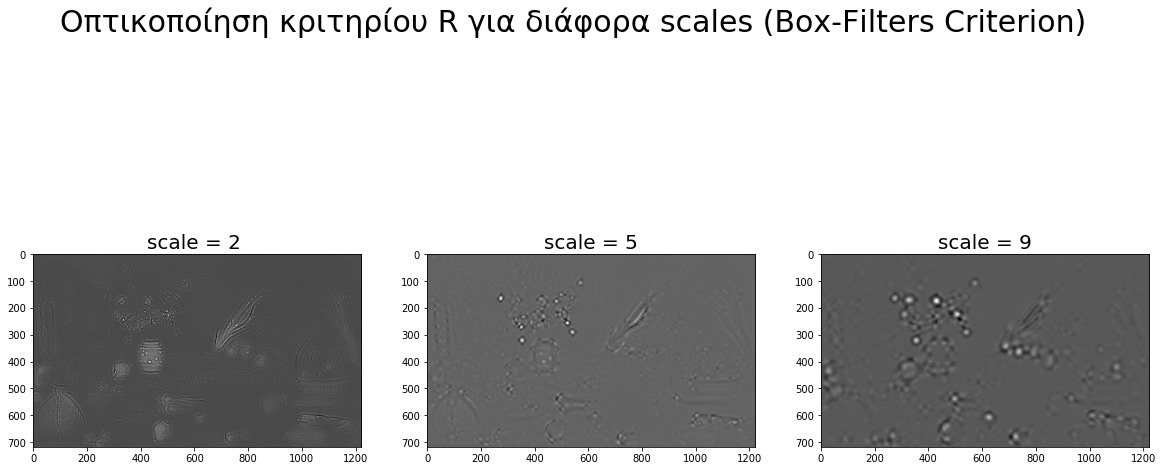

In [29]:
R1= box_filters_criterion(n_img1,2.2)
R2= box_filters_criterion(n_img1,5.2)
R3= box_filters_criterion(n_img1,9.2)

f, (ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(20, 10))

f.suptitle('Οπτικοποίηση κριτηρίου R για διάφορα scales (Βox-Filters Criterion)',fontsize=30)

ax0.imshow(R1,cmap='gray')
ax0.set_title("scale = 2 ",fontsize=20)

ax1.imshow(R2,cmap='gray')
ax1.set_title("scale = 5" , fontsize=20)

ax2.imshow(R3,cmap='gray')
ax2.set_title("scale = 9" , fontsize=20)

# *ΤΕΛΟΣ ΠΡΩΤΗΣ ΕΡΓΑΣΤΗΡΙΑΚΗΣ ΑΣΚΗΣΗΣ*